In [1]:
# Before running the script, you might need to run this command lines first:
# python -m venv env
# env\Scripts\activate
# ...
# %pip install numpy matplotlib IPython

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['lines.markersize'] = 10
fig = plt.figure()

<Figure size 2000x1000 with 0 Axes>

In [2]:
img1 = fig.add_subplot(131)
img1.set_aspect('equal')

img2 = fig.add_subplot(132)
img2.set_aspect('equal')

img3 = fig.add_subplot(133)
img3.set_aspect('equal')

def init_params(points):
    if points >= 50: # Change the layers
        layers = [2, 50, 50, 25, 10, 1]
    else:
        layers = [2, 50, 25, 10, 1]
    w = []
    for i in range(len(layers)-1):
        w.append(np.random.randn(layers[i+1], layers[i]))
    b = []
    for i in w:
        b.append(np.random.randn(len(i.T[0]), 1))
    lr = 0.1
    return w, b, lr

def create_map():
    XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    pred_map = np.hstack((XX.reshape(-1, 1), YY.reshape(-1, 1)))
    return XX, YY, pred_map
XX, YY, pred_map = create_map()

def get_accmap(w, b, img, x, y, lb, map_axis):
    acc = 0
    img.clear()
    img.axis(map_axis)
    for i in range(len(x)):
        l0 = np.array([[x[i]], [y[i]]])
        target = lb[i]
        l = get_guess(w, b, l0)
        if l[-1] == target:
            img.plot(l0[0], l0[1], 'go')
            acc += 1
        else:
            img.plot(l0[0], l0[1], 'ro')
    return acc

def get_predmap(w, b, img):
    img.clear()
    Z = []
    for i in pred_map:
        l0 = np.array([[i[0]], [i[1]]])
        l = get_guess(w, b, l0)
        Z.append(l[-1])
    Z = np.array(Z)
    Z = Z.reshape(XX.shape)
    img.contourf(XX, YY, Z, cmap="cool", alpha=0.5)

sigmoid = lambda x: 1/(1+np.exp(-x))
der_sigmoid = lambda x: x*(1-x)

def sign(x):
    lx = []
    for i in x:
        if i[0] > 0:
            lx.append([1])
        else:
            lx.append([-1])
    return np.array(lx)

def get_guess(w, b, l0):
    l = [l0]
    for i in range(len(w)-1):
        # l.append(relu(w[i].dot(l[i]) + b[i]))
        l.append(sigmoid(w[i].dot(l[i]) + b[i]))
    l.append(sign(w[-1].dot(l[-1]) + b[-1]))
    return l

def train(w, b, l, target, lr):
    d = [target - l[-1]]
    for i in range(len(l)-2):
        # d.append(der_relu(w[-(1+i)].T.dot(d[-1]), l[-(2+i)]))
        # d.append(der_sigmoid(w[-(1+i)].T.dot(d[-1]), l[-(2+i)]))
        d.append(w[-(1+i)].T.dot(d[-1]) * der_sigmoid(l[-(2+i)]))
    for i in range(len(w)):
        w[-(1+i)] += d[i] * l[-(2+i)].T * lr
        b[-(1+i)] += d[i] * lr

In [3]:
def DotSeparator(points, logOccurence, errorMargin, minIters, map_axis, show_graphs):
    x = np.random.random(points)
    y = np.random.random(points)
    lb = []
    w, b, lr = init_params(points)

    img1.clear()
    img1.axis(map_axis)
    for i in range(len(x)):
        n = np.random.choice([-1, 1])
        # n = int(x[i]>y[i])*2-1
        lb.append(n)
        if n == 1:
            img1.plot(x[i], y[i], 'mo')
        else:
            img1.plot(x[i], y[i], 'co')

    iters = 0
    hst_acc = 0
    is_done = False
    # time_start = time.time()
    while not is_done:
        acc = 0
        iters += 1
        for i in range(len(x)):
            l0 = np.array([[x[i]], [y[i]]])
            target = lb[i]
            l = get_guess(w, b, l0)
            if l[-1] == target:
                if show_graphs and iters % logOccurence == 0: img2.plot(l0[0], l0[1], 'go')
                acc += 1
            else:
                if show_graphs and iters % logOccurence == 0: img2.plot(l0[0], l0[1], 'ro')
            train(w, b, l, target, lr)
        hst_acc = np.maximum(hst_acc, acc/len(x))
        # if hst_acc >= 1-(np.floor((time.time()-time_start)/1200)*errorMargin):
        if hst_acc >= 1-(np.floor(iters/minIters)*errorMargin) and hst_acc == acc/len(x):
            is_done = True
        if iters % logOccurence == 0 or is_done:
            if show_graphs:
                acc = get_accmap(w, b, img2, x, y, lb, map_axis)
                hst_acc = np.maximum(hst_acc, acc/len(x))
                get_predmap(w, b, img3)
                display.display(f'Iterations: {str(iters)} - Accuracy: {str(acc/len(x))} ({hst_acc})', fig)
            else:
                print(f'Iterations: {str(iters)} - Accuracy: {str(acc/len(x))} ({hst_acc})')
            display.clear_output(wait=True)
    return x, y, lb, w, b

'Iterations: 10740 - Accuracy: 1.0 (1.0)'

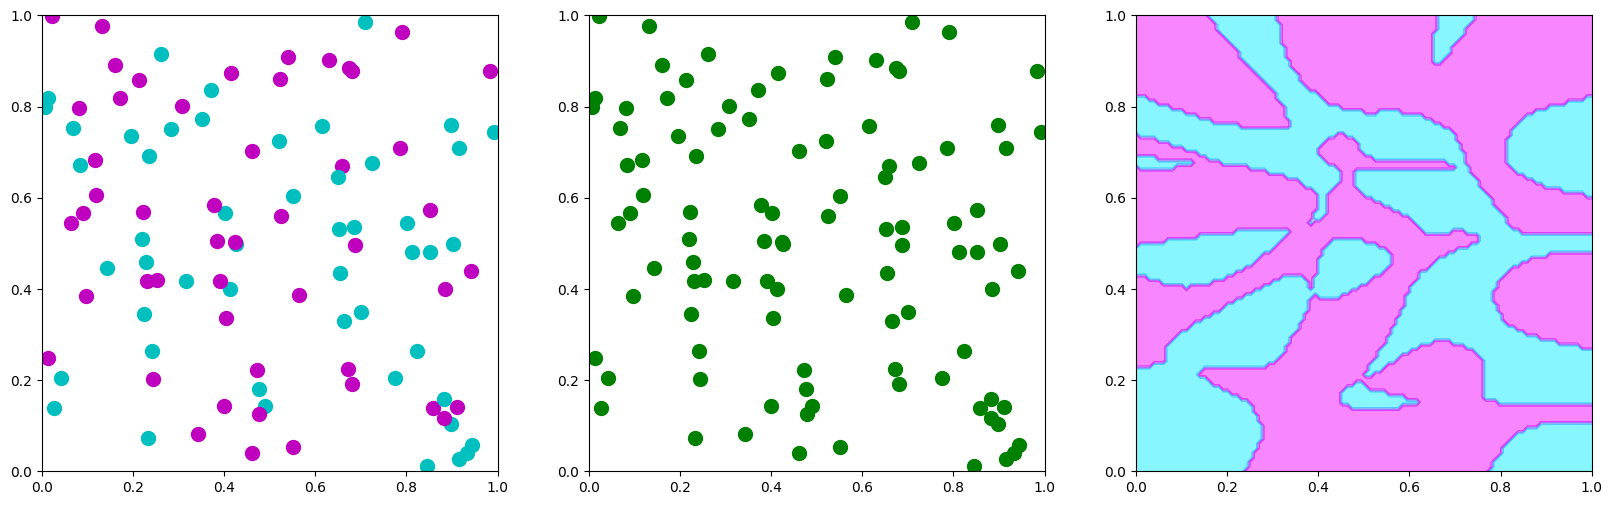

In [4]:
points = 100 # change the amount of points
logOccurence = 500  # Change the log occurence
errorMargin = 0.00 # set the error margin after it reaches the minimum iterations
minIters = 10000 # set the minimum iterations before it accounts for error margin
map_axis = [0,1,0,1] # set the limits for the maps' axis /  [0,1,0,1] ; [-0.2,1.2,-0.2,1.2]
show_graphs = True # Set if the graph apper every [logOccurence] iteration

x, y, lb, w, b = DotSeparator(points, logOccurence, errorMargin, minIters, map_axis, show_graphs)

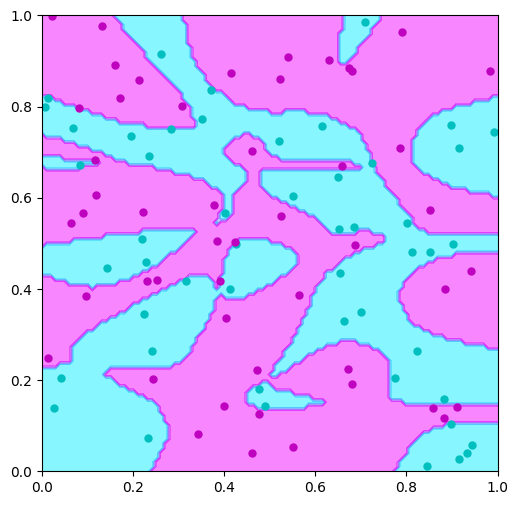

In [5]:
img4 = plt.figure().add_subplot(131)
img4.set_aspect("equal")
img4.axis(map_axis)
get_predmap(w, b, img4)
for i in range(len(x)):
    if lb[i] == 1:
        img4.plot(x[i], y[i], 'mo', ms=5)
    else:
        img4.plot(x[i], y[i], 'co', ms=5)